# Projeto 1 - FGV QUANT
## Otimização de Portfólio (Markowitz) e Tomada de Decisão

- A escolha será baseada no Índice Brasil 50 (IBrX 50 B3) data: 20/05/21

- Comparar EW x CW x GMV x MSR \
  . EW = EqualWeighted \
  . CW =  CapWeighted \
  . GMV = Global Minimum Variance \
  . MSR = Maximum Sharpe Ratio

- Parâmetros da Otimização \
  . Risk free = SELIC 10 anos \
  . Apenas Long
 
- Fazer uma Análise de Fatores de Risco (CAPM e o Fama-French)

- Backtest
- Colocar aportes mensais
- Não mudar os pesos

Referências:
https://github.com/HugoAzv/Investment-Management/blob/main/2.%20Advanced%20Portfolio%20Construction%20and%20Analysis%20with%20Python/Module%201%20Lab%20Session%20-%20Foundations.ipynb

https://github.com/HugoAzv/Investment-Management/blob/main/2.%20Advanced%20Portfolio%20Construction%20and%20Analysis%20with%20Python/Module%202%20Lab%20Session%20-%20Covariance%20Estimation.ipynb

# 1 - Importando as Bibliotecas

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from selenium import webdriver
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")

# 2 - Coletando os dados

In [2]:
inicio = '01-01-2015'
fim = '01-01-2020'

In [3]:
ibovespa = ['^BVSP']
tickers = ['ELET3.SA', 'TRPL4.SA', 'TAEE11.SA', 'VIVT3.SA', 'CYRE3.SA', 'BBAS3.SA', 'SANB11.SA', 'BBSE3.SA'] + ibovespa
tickers

['ELET3.SA',
 'TRPL4.SA',
 'TAEE11.SA',
 'VIVT3.SA',
 'CYRE3.SA',
 'BBAS3.SA',
 'SANB11.SA',
 'BBSE3.SA',
 '^BVSP']

In [4]:
# # DataFrame para carregar os preços dos tickers
# prices = pd.DataFrame()

# # for ticker in tickers:
# #     if ticker != '^BVSP':
# #         prices[ticker] = data.DataReader(ticker+'.SA', data_source='yahoo', start=inicio, end=fim)['Adj Close']
# #     else:
# #         prices[ticker] = data.DataReader(ticker, data_source='yahoo', start=inicio, end=fim)['Adj Close']

# for ticker in tickers:
#     prices[ticker] = data.DataReader(ticker, data_source='yahoo', start=inicio, end=fim)['Adj Close']
        
# # Ajustar o Índice e a coluna do IBOV
# prices.index.name = 'Date'
# prices = prices.rename(columns = {'^BVSP':'IBOV'})

# # Salvar o DataFrame para futuras aplicações
# prices.to_csv('carteira_2015_a_2020.csv')

In [5]:
carteira = pd.read_csv('carteira_2015_a_2020.csv', header=0, index_col=0, na_values=-99.99)
rets_carteira = carteira.pct_change().dropna()
rets_carteira.head()

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA,IBOV
Date,,,,,,,,,
2015-01-05,-0.019435,0.001229,-0.003713,-0.019830,0.025837,-0.020750,-0.007076,-0.029983,-0.020510
2015-01-06,0.009009,-0.005644,0.001597,-0.024818,0.027985,0.013976,0.007126,0.042459,0.010186
2015-01-07,0.035714,0.028628,0.001595,0.034302,0.026316,0.044020,0.041667,-0.015966,0.030458
2015-01-08,-0.018965,0.006478,0.009554,0.040652,0.007958,0.003407,-0.016604,-0.002980,0.009704
2015-01-09,-0.021090,-0.082718,-0.006835,-0.015934,-0.053509,-0.043294,-0.009977,-0.032547,-0.022085


In [6]:
ativos = carteira.iloc[:,:-1]
ativos.head()

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA
Date,,,,,,,,
2015-01-02,4.591455,6.112401,9.385139,23.768299,7.681489,15.901145,8.792006,18.853855
2015-01-05,4.502222,6.119913,9.350287,23.296963,7.879957,15.571194,8.729797,18.288551
2015-01-06,4.542781,6.085372,9.365224,22.718771,8.100478,15.788818,8.792006,19.065069
2015-01-07,4.705024,6.259582,9.380158,23.498070,8.313648,16.483839,9.158340,18.760674
2015-01-08,4.615792,6.300130,9.469777,24.453323,8.379807,16.539999,9.006276,18.704763


In [7]:
ibov = carteira[['IBOV']]
ibov.head()

,IBOV
Date,
2015-01-02,48512.0
2015-01-05,47517.0
2015-01-06,48001.0
2015-01-07,49463.0
2015-01-08,49943.0


# 3 - Análise Exploratória

## 3.1 - Retorno dos Ativos

In [8]:
rets_acoes = rets_carteira.iloc[:,:-1] # Retornos diários
rets_acoes.head()

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA
Date,,,,,,,,
2015-01-05,-0.019435,0.001229,-0.003713,-0.019830,0.025837,-0.020750,-0.007076,-0.029983
2015-01-06,0.009009,-0.005644,0.001597,-0.024818,0.027985,0.013976,0.007126,0.042459
2015-01-07,0.035714,0.028628,0.001595,0.034302,0.026316,0.044020,0.041667,-0.015966
2015-01-08,-0.018965,0.006478,0.009554,0.040652,0.007958,0.003407,-0.016604,-0.002980
2015-01-09,-0.021090,-0.082718,-0.006835,-0.015934,-0.053509,-0.043294,-0.009977,-0.032547


In [9]:
rets_acoes.describe()

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA
count,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000,1240.000000
mean,0.002202,0.001057,0.000945,0.000644,0.001249,0.001292,0.001545,0.000641
std,0.036853,0.015148,0.015783,0.018497,0.022671,0.027561,0.021508,0.019611
min,-0.209698,-0.082718,-0.083085,-0.102649,-0.162632,-0.211712,-0.111470,-0.102251
25%,-0.017886,-0.007631,-0.008709,-0.009338,-0.011912,-0.013858,-0.011557,-0.010685
50%,0.000000,0.000819,0.000485,0.000000,0.000000,0.000216,0.000863,0.000102
75%,0.018778,0.009856,0.010576,0.011045,0.014981,0.015875,0.014421,0.011288
max,0.492958,0.102339,0.087322,0.091172,0.116764,0.143725,0.088235,0.109071


In [10]:
rets_acoes.isnull().sum()

ELET3.SA     0
TRPL4.SA     0
TAEE11.SA    0
VIVT3.SA     0
CYRE3.SA     0
BBAS3.SA     0
SANB11.SA    0
BBSE3.SA     0
dtype: int64

<Figure size 432x288 with 0 Axes>

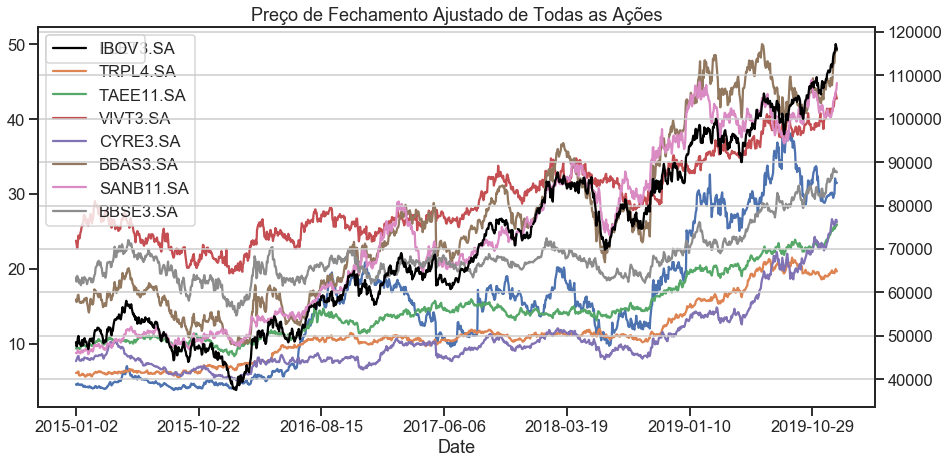

In [11]:
fig = plt.figure();
ax1 = ativos.plot(figsize=(15,7), title='Preço de Fechamento Ajustado de Todas as Ações');
ax2 = ax1.twinx();
ibov.plot(ax=ax2, color='black', style='-');
plt.legend();
plt.grid();

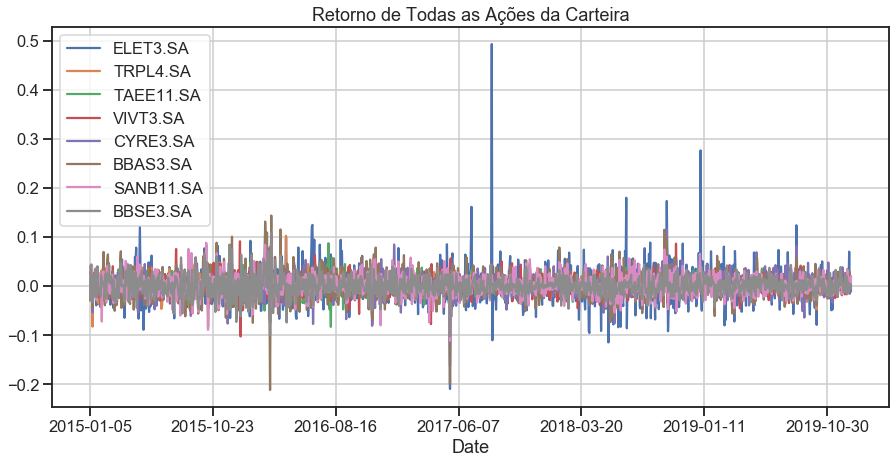

In [12]:
rets_acoes.plot(figsize=(15,7), title='Retorno de Todas as Ações da Carteira');
plt.legend()
plt.grid()

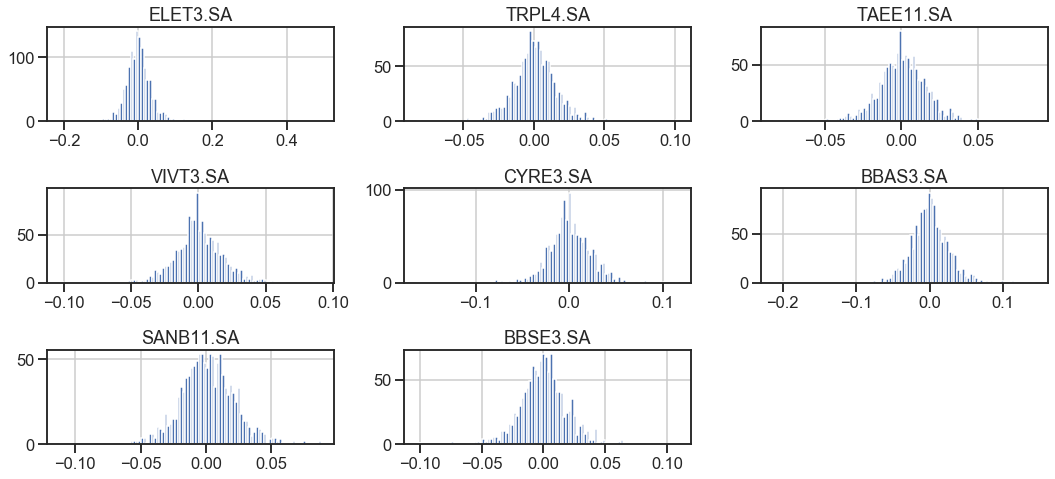

In [13]:
rets_acoes.hist(bins=100, figsize=(15,7));
plt.tight_layout()

## 3.2 - Retorno do Ibovespa no período

In [14]:
rets_ibov = rets_carteira[['IBOV']] # Retornos diários
rets_ibov.head(5)

,IBOV
Date,
2015-01-05,-0.020510
2015-01-06,0.010186
2015-01-07,0.030458
2015-01-08,0.009704
2015-01-09,-0.022085


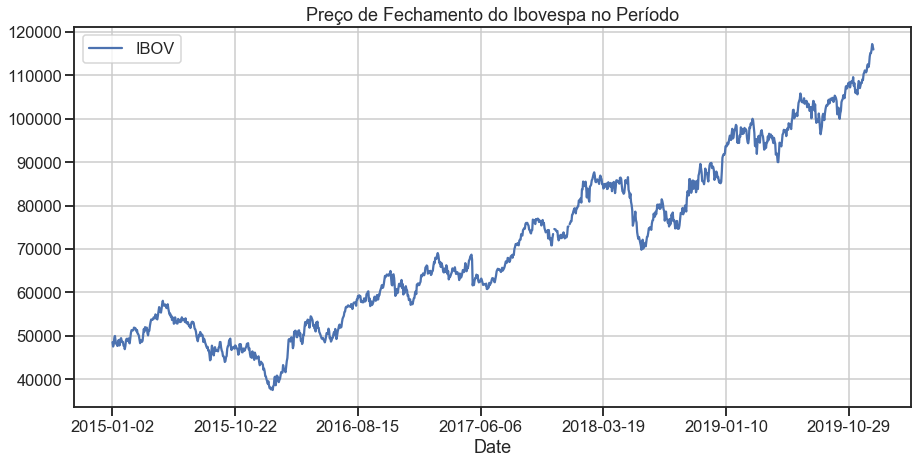

In [15]:
ibov.plot(figsize=(15,7), title='Preço de Fechamento do Ibovespa no Período');
plt.legend()
plt.grid()

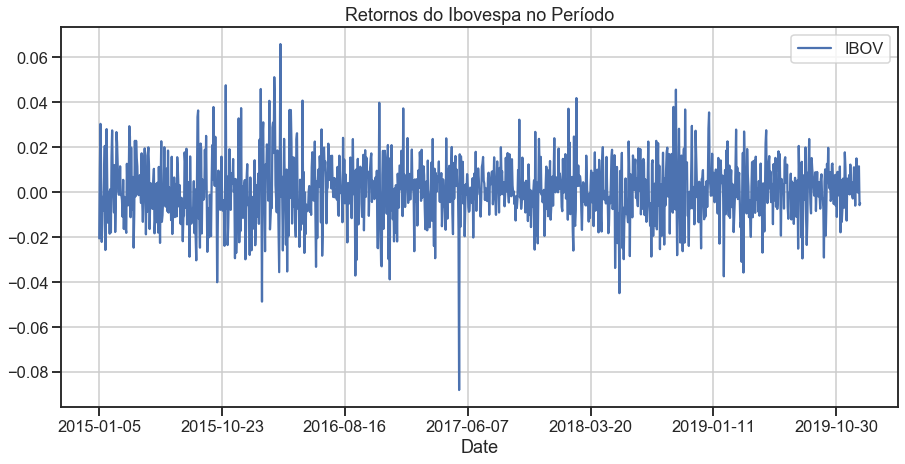

In [16]:
rets_ibov.plot(figsize=(15,7), title='Retornos do Ibovespa no Período');
plt.legend()
plt.grid()

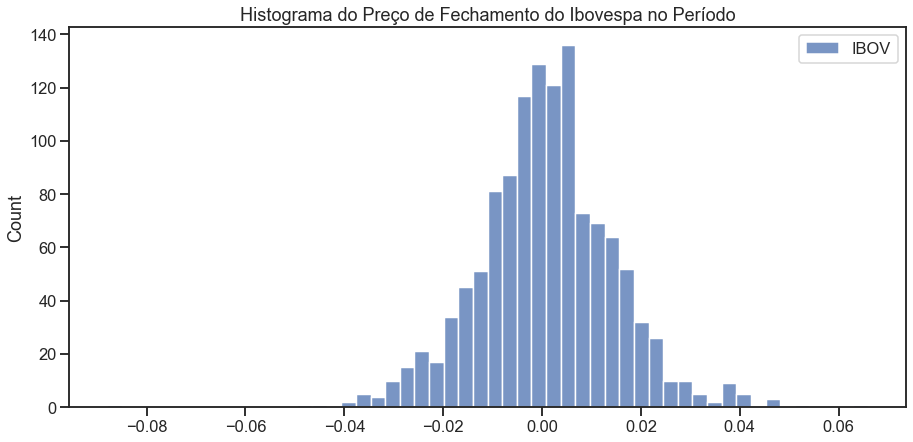

In [17]:
plt.figure(figsize = (15,7))
ax = sns.histplot(rets_ibov)
plt.title('Histograma do Preço de Fechamento do Ibovespa no Período');

# 4 - Correlação dos ativos com o ibovespa

In [18]:
corr_carteira = carteira.pct_change().dropna()
corr_carteira.head()

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA,IBOV
Date,,,,,,,,,
2015-01-05,-0.019435,0.001229,-0.003713,-0.019830,0.025837,-0.020750,-0.007076,-0.029983,-0.020510
2015-01-06,0.009009,-0.005644,0.001597,-0.024818,0.027985,0.013976,0.007126,0.042459,0.010186
2015-01-07,0.035714,0.028628,0.001595,0.034302,0.026316,0.044020,0.041667,-0.015966,0.030458
2015-01-08,-0.018965,0.006478,0.009554,0.040652,0.007958,0.003407,-0.016604,-0.002980,0.009704
2015-01-09,-0.021090,-0.082718,-0.006835,-0.015934,-0.053509,-0.043294,-0.009977,-0.032547,-0.022085


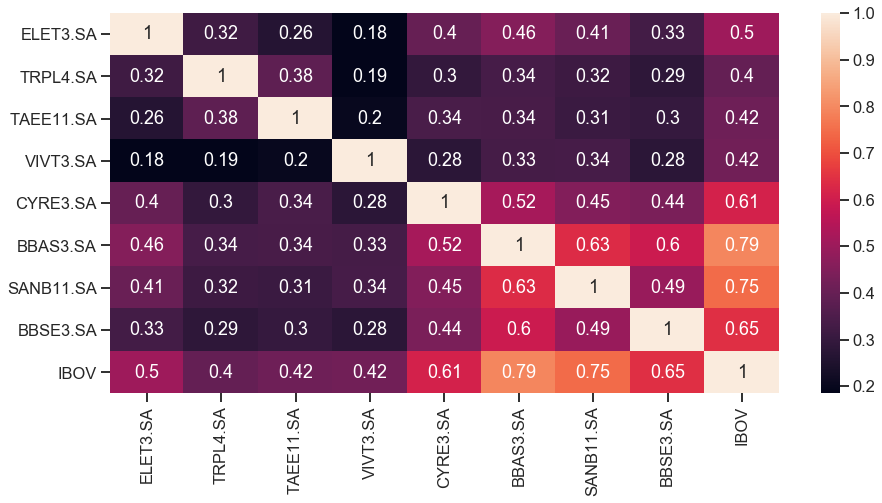

In [19]:
plt.figure(figsize = (15,7))
ax = sns.heatmap(corr_carteira.corr(), annot = True)

<Figure size 1080x504 with 0 Axes>

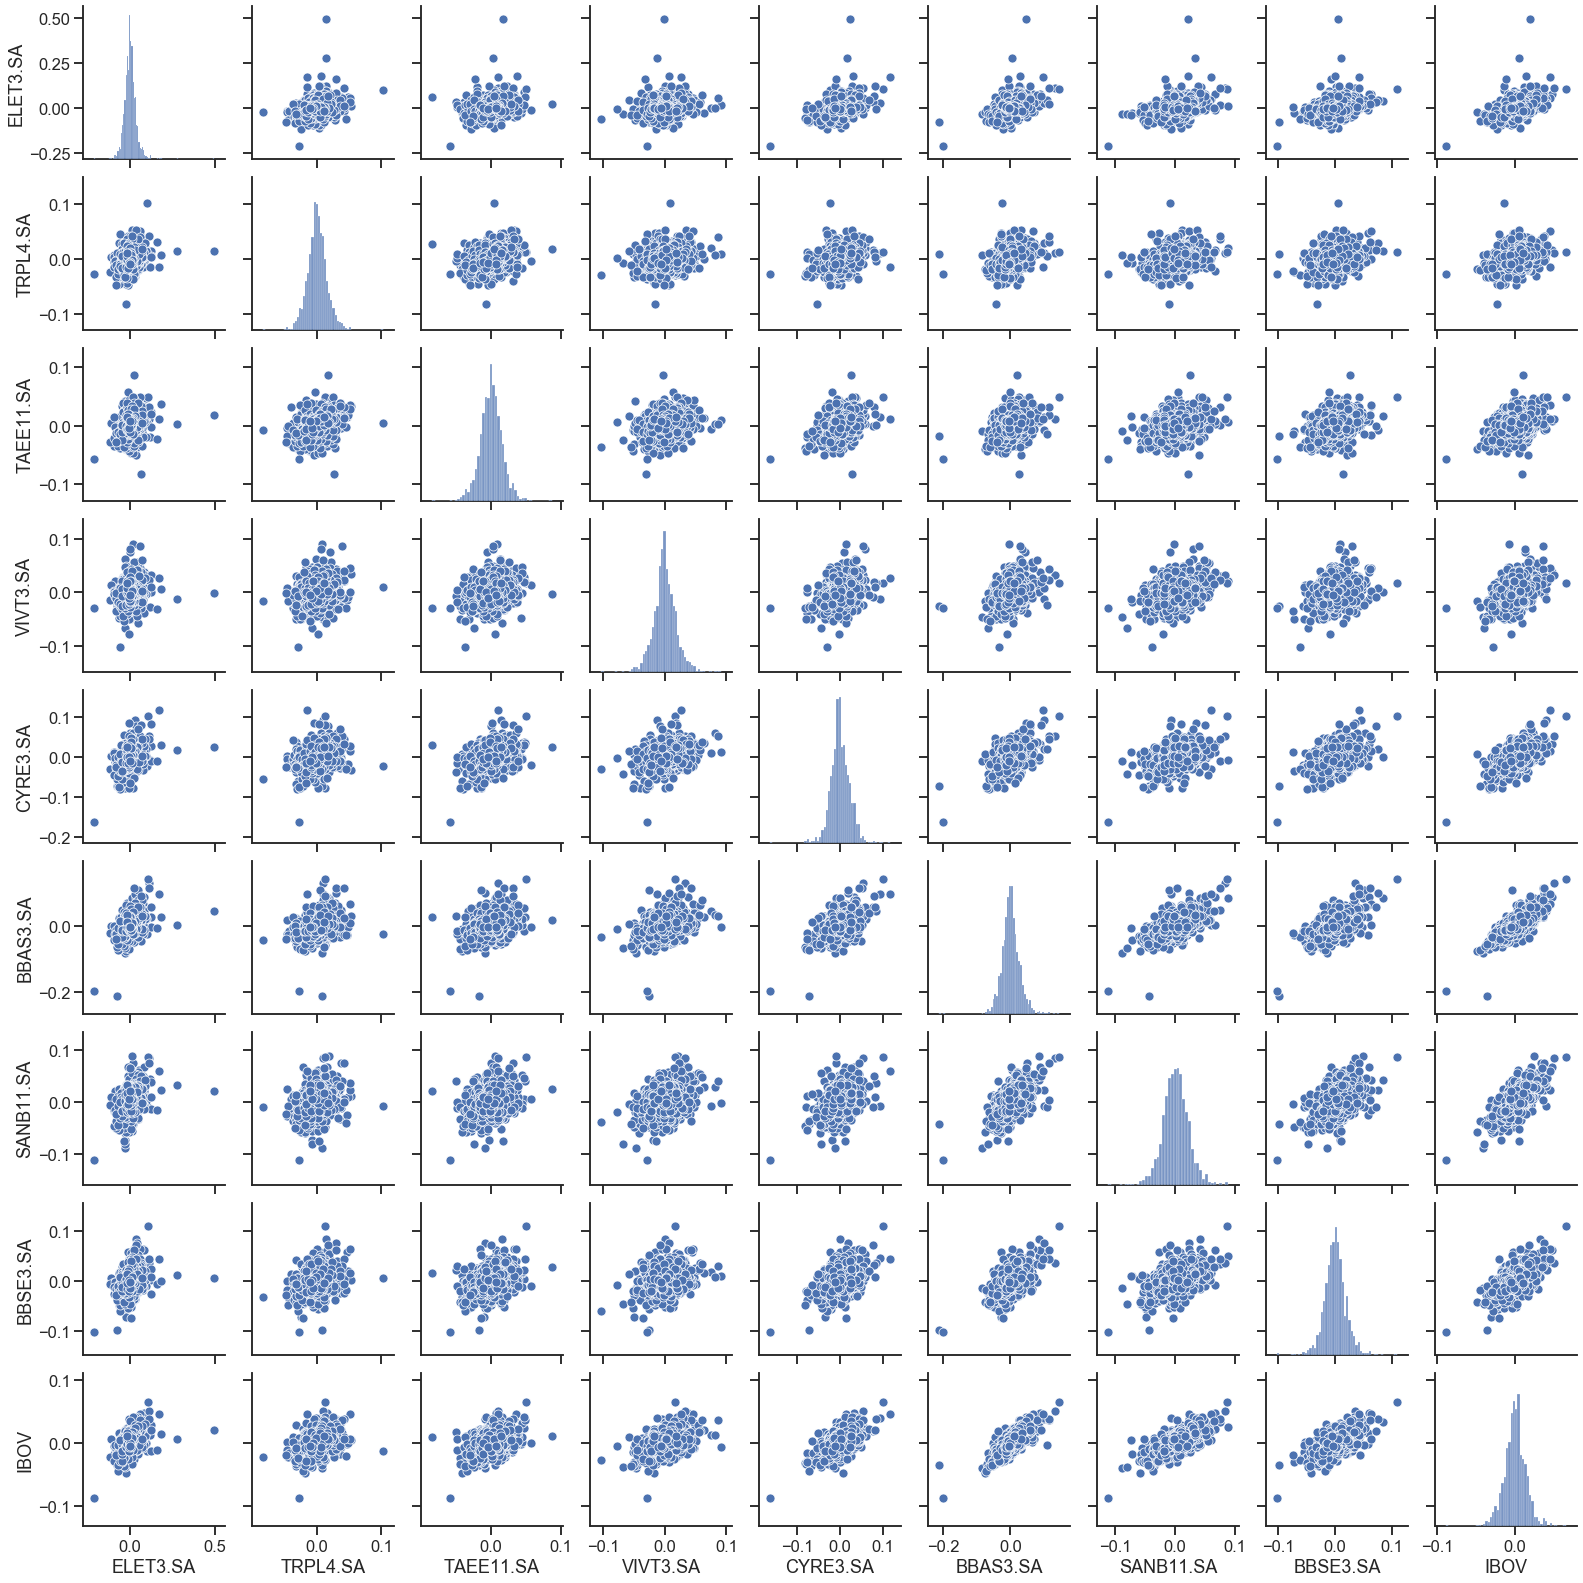

In [20]:
plt.figure(figsize = (15,7))
ax = sns.pairplot(corr_carteira)

# 5 - Retornos Acumulados

In [21]:
rets_acumulado = (rets_acoes + 1).cumprod()
rets_acumulado['IBOV'] = (rets_ibov + 1).cumprod()
rets_acumulado.tail(5)

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA,IBOV
Date,,,,,,,,,
2019-12-20,6.528966,3.177311,2.698058,1.791308,3.361257,2.987376,4.886324,1.746848,2.373042
2019-12-23,6.986248,3.232854,2.712300,1.796808,3.369321,3.077476,4.881155,1.756568,2.388337
2019-12-26,6.877371,3.269881,2.752357,1.829444,3.455714,3.112581,4.966970,1.747773,2.415959
2019-12-27,6.848338,3.247095,2.741675,1.808909,3.458017,3.099124,4.994886,1.751476,2.402169
2019-12-30,6.859225,3.215764,2.764819,1.798275,3.420004,3.090348,5.097245,1.744996,2.390419


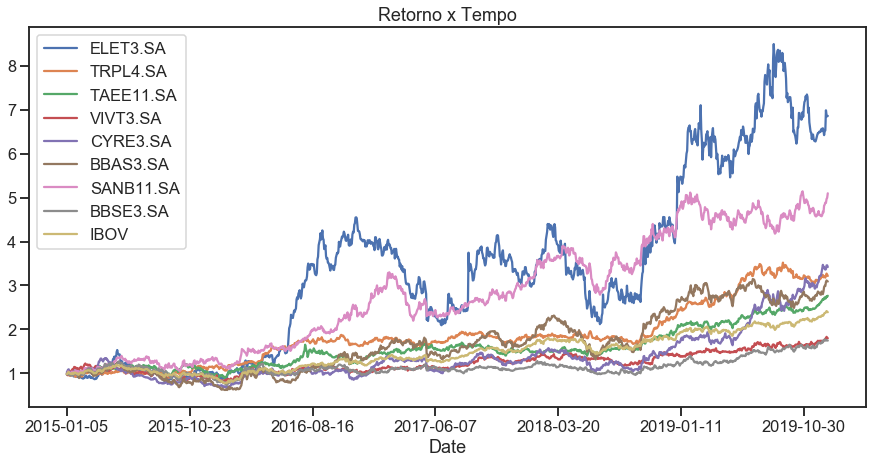

In [22]:
rets_acumulado.plot(title='Retorno x Tempo', figsize = (15,7));

# 6 - Ajuste ao Risco

In [23]:
vol = rets_carteira.std() # volatilidade no período
vol_anualizada = vol*np.sqrt(12) # vol anualizada

In [24]:
vol

ELET3.SA     0.036853
TRPL4.SA     0.015148
TAEE11.SA    0.015783
VIVT3.SA     0.018497
CYRE3.SA     0.022671
BBAS3.SA     0.027561
SANB11.SA    0.021508
BBSE3.SA     0.019611
IBOV         0.013853
dtype: float64

In [25]:
vol_anualizada

ELET3.SA     0.127664
TRPL4.SA     0.052473
TAEE11.SA    0.054672
VIVT3.SA     0.064075
CYRE3.SA     0.078534
BBAS3.SA     0.095476
SANB11.SA    0.074505
BBSE3.SA     0.067933
IBOV         0.047988
dtype: float64

In [26]:
num_dias = rets_carteira.shape[0]
rets_anualizado = (rets_carteira+1).prod()**(252/num_dias) - 1
rets_anualizado

ELET3.SA     0.478947
TRPL4.SA     0.267924
TAEE11.SA    0.229584
VIVT3.SA     0.126661
CYRE3.SA     0.283891
BBAS3.SA     0.257715
SANB11.SA    0.392351
BBSE3.SA     0.119796
IBOV         0.193756
dtype: float64

In [27]:
retorno_livre_de_risco = 0.13 # Fixo em 13% pq? Pq sim
excess_return = rets_anualizado - retorno_livre_de_risco
sharpe_ratio = excess_return/vol_anualizada
sharpe_ratio

ELET3.SA     2.733334
TRPL4.SA     2.628456
TAEE11.SA    1.821466
VIVT3.SA    -0.052107
CYRE3.SA     1.959538
BBAS3.SA     1.337670
SANB11.SA    3.521273
BBSE3.SA    -0.150208
IBOV         1.328597
dtype: float64

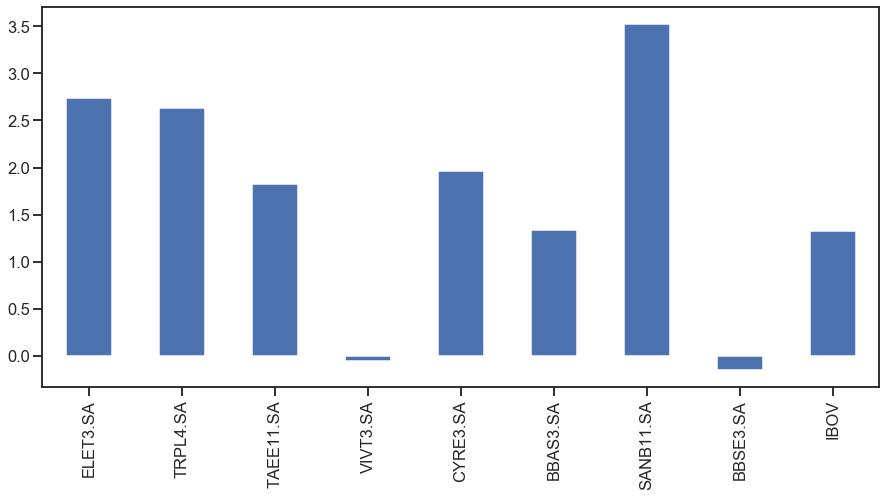

In [28]:
sharpe_ratio.plot.bar(figsize=(15,7));

# 7 - Calcular Drawdowns

In [29]:
def drawdown(return_series: pd.Series):
    """
    Takes a time series of asset returns
    Computes and returns a DataFrame that contains:
    the wealth index
    the previous peaks
    percent drawdons
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawndowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks" : previous_peaks,
        "Drawdown": drawndowns
    })

In [41]:
max_drawdowns = []
for i in range(rets_carteira.shape[1]):
    aux = drawdown(rets_carteira.iloc[:,i])["Drawdown"].min()
    max_drawdowns.append(aux)
max_drawdowns

[-0.539984424888743,
 -0.16481474088660464,
 -0.267950748356739,
 -0.33223483801320103,
 -0.5043892771842231,
 -0.5096869391214922,
 -0.33417373773937054,
 -0.4217490221298009,
 -0.3540791014952112]

<BarContainer object of 9 artists>

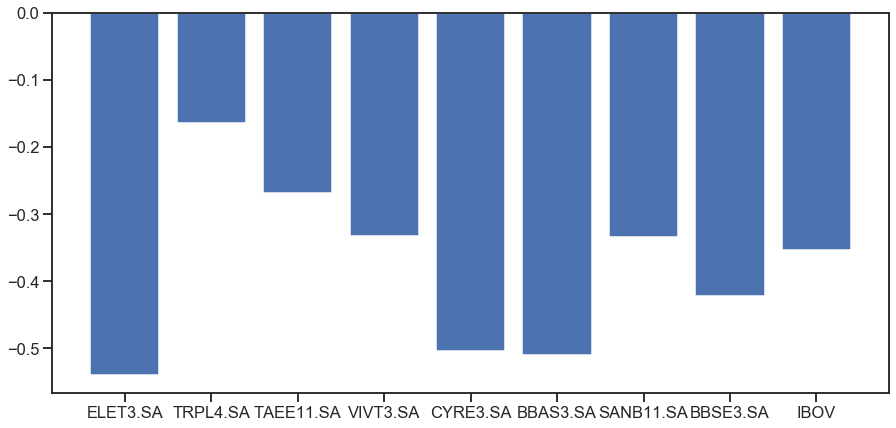

In [45]:
plt.figure(figsize=(15,7))
plt.bar(rets_carteira.columns.tolist(), max_drawdowns)

# 8 - Testar Normalidade

In [46]:
import scipy.stats as ss

## 8.1 - Skewness

In [47]:
def skewness(r):
    demeaned_r = r - r.mean()
    # usar o std da população, ddof = 0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

In [48]:
S = skewness(rets_carteira)
S

ELET3.SA     2.429685
TRPL4.SA     0.189034
TAEE11.SA   -0.010214
VIVT3.SA     0.123487
CYRE3.SA    -0.102058
BBAS3.SA    -0.125299
SANB11.SA   -0.019360
BBSE3.SA     0.072920
IBOV        -0.077842
dtype: float64

## 8.2 - Kurtosis

In [49]:
def kurtosis(r):
    demeaned_r = r - r.mean()
    # usar o std da população, ddof = 0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

In [50]:
K = kurtosis(rets_carteira)
K

ELET3.SA     32.096378
TRPL4.SA      5.567390
TAEE11.SA     4.634377
VIVT3.SA      5.403803
CYRE3.SA      6.604482
BBAS3.SA      9.460043
SANB11.SA     4.641706
BBSE3.SA      5.631774
IBOV          5.140795
dtype: float64

## 8.3 - Jarque Berat

In [51]:
def is_normal(r, level=0.01):
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = ss.jarque_bera(r)
        return p_value > level

In [52]:
normality = is_normal(rets_carteira)
normality

ELET3.SA     False
TRPL4.SA     False
TAEE11.SA    False
VIVT3.SA     False
CYRE3.SA     False
BBAS3.SA     False
SANB11.SA    False
BBSE3.SA     False
IBOV         False
dtype: bool

# 9 - Medidas de Risco

## 9.1 - Semideviation

In [53]:
def semideviation(r):
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [54]:
semi_dev = semideviation(rets_carteira)
semi_dev

ELET3.SA     0.020591
TRPL4.SA     0.009492
TAEE11.SA    0.010132
VIVT3.SA     0.011998
CYRE3.SA     0.014882
BBAS3.SA     0.018373
SANB11.SA    0.013666
BBSE3.SA     0.012723
IBOV         0.009135
dtype: float64

## 9.2 - Var and CVaR
Value at Risk

- Historic VaR
- Parametric VaR - Gaussian
- Modified Cornish-Fisher VaR

### 9.2.1 - Historic VaR

In [77]:
def var_historic(r, level=5):
    """
    VaR Historic
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be Series or DataFrame")

In [78]:
VaR_historic = var_historic(rets_carteira)
VaR_historic

ELET3.SA     0.048230
TRPL4.SA     0.023654
TAEE11.SA    0.024676
VIVT3.SA     0.028998
CYRE3.SA     0.031481
BBAS3.SA     0.039474
SANB11.SA    0.032177
BBSE3.SA     0.029281
IBOV         0.022533
dtype: float64

### 9.2.2 - Parametric VaR - Gaussian

In [79]:
def var_gaussian(r, S, K, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = ss.norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = S
        k = K
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

In [80]:
VaR_gaussian = var_gaussian(rets_carteira, S, K)
VaR_gaussian

ELET3.SA     0.058392
TRPL4.SA     0.023849
TAEE11.SA    0.025005
VIVT3.SA     0.029768
CYRE3.SA     0.036026
BBAS3.SA     0.044025
SANB11.SA    0.033817
BBSE3.SA     0.031603
IBOV         0.021978
dtype: float64

### 9.2.3 - Modified Cornish-Fisher VaR

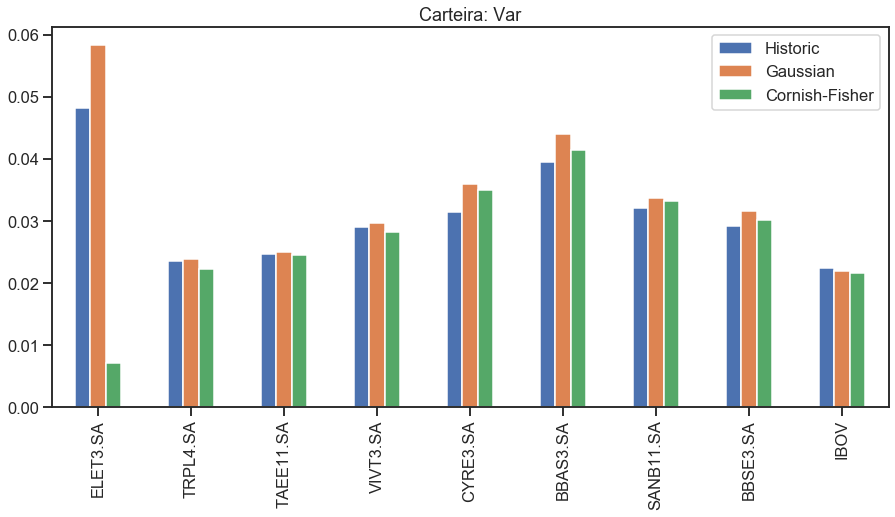

In [82]:
VaR_list = [var_historic(rets_carteira), var_gaussian(rets_carteira, S, K), var_gaussian(rets_carteira, S, K, modified=True)]
comparação = pd.concat(VaR_list, axis = 1)
comparação.columns = ["Historic", "Gaussian", "Cornish-Fisher"]
comparação.plot.bar(figsize=(15,7), title = "Carteira: Var");

### 9.2.4 - BeyondVar aka CVar

In [83]:
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [86]:
cVaR_historic = cvar_historic(rets_carteira)
cVaR_historic

ELET3.SA     0.067474
TRPL4.SA     0.031302
TAEE11.SA    0.033870
VIVT3.SA     0.039458
CYRE3.SA     0.048034
BBAS3.SA     0.055943
SANB11.SA    0.045531
BBSE3.SA     0.042291
IBOV         0.029618
dtype: float64

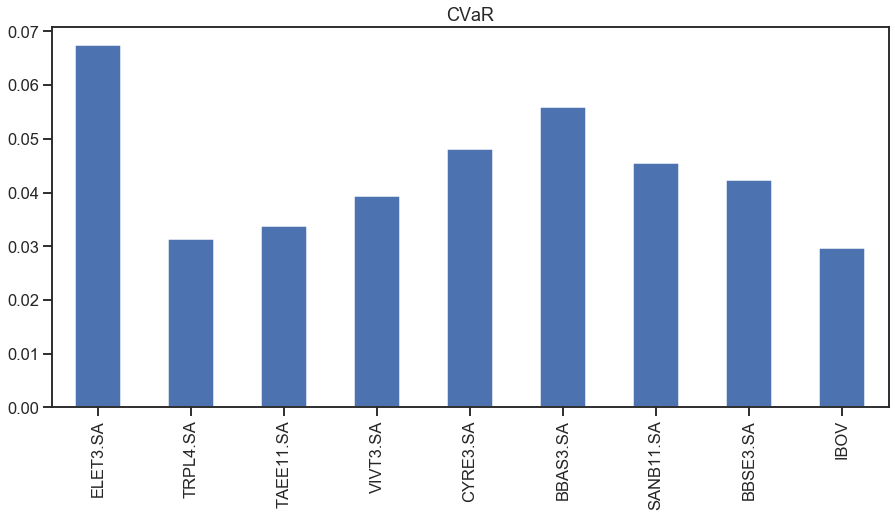

In [87]:
cVaR_historic.plot.bar(figsize=(15,7), title = "CVaR");

# 10 - Analisando o Portfolio via Markowitz

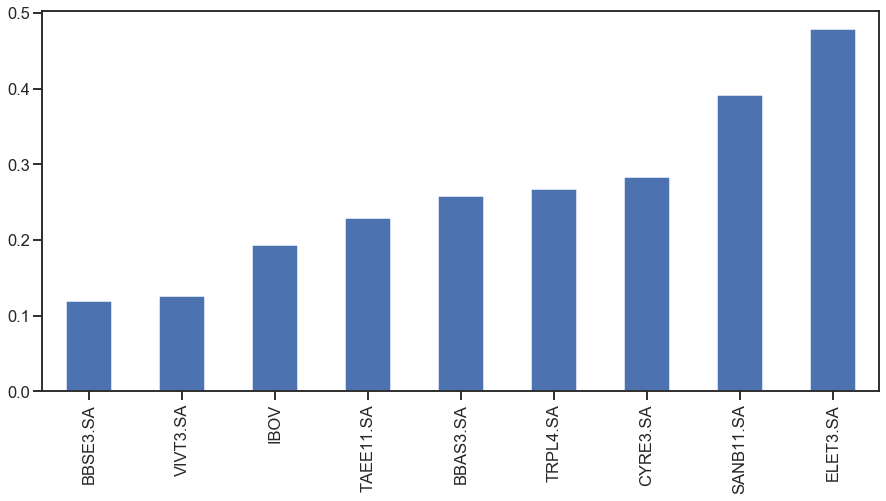

In [89]:
rets_anualizado.sort_values().plot.bar(figsize=(15,7));

In [121]:
cov = rets_acoes.cov()
cov

,ELET3.SA,TRPL4.SA,TAEE11.SA,VIVT3.SA,CYRE3.SA,BBAS3.SA,SANB11.SA,BBSE3.SA
ELET3.SA,0.001358,0.000179,0.000154,0.000126,0.000333,0.000464,0.000322,0.000237
TRPL4.SA,0.000179,0.000229,0.000092,0.000052,0.000101,0.000140,0.000103,0.000085
TAEE11.SA,0.000154,0.000092,0.000249,0.000059,0.000122,0.000148,0.000105,0.000093
VIVT3.SA,0.000126,0.000052,0.000059,0.000342,0.000116,0.000170,0.000134,0.000101
CYRE3.SA,0.000333,0.000101,0.000122,0.000116,0.000514,0.000326,0.000221,0.000194
BBAS3.SA,0.000464,0.000140,0.000148,0.000170,0.000326,0.000760,0.000376,0.000322
SANB11.SA,0.000322,0.000103,0.000105,0.000134,0.000221,0.000376,0.000463,0.000209
BBSE3.SA,0.000237,0.000085,0.000093,0.000101,0.000194,0.000322,0.000209,0.000385


In [94]:
def portfolio_return(weights, returns):
    """
    Weights -> Returns
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Weights -> Vol
    """
    return (weights.T @ covmat @ weights)**0.5

## 10.1 - Portfolio com Pesos Iguais dos Ativoso = EW

In [123]:
w_ew = np.repeat(1/rets_acoes.shape[1], rets_acoes.shape[1])
r_ew = portfolio_return(w_ew, rets_anualizado[:-1])
v_ew = portfolio_vol(w_ew, cov)
w_ew

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

In [128]:
df_ew = pd.DataFrame({'Ações':rets_anualizado[:-1].index.tolist(),
                       'Pesos':w_ew,
                       'Retornos':r_ew,
                       'Vol':v_ew})
df_ew

,Ações,Pesos,Retornos,Vol
0,ELET3.SA,0.125,0.269609,0.015034
1,TRPL4.SA,0.125,0.269609,0.015034
2,TAEE11.SA,0.125,0.269609,0.015034
3,VIVT3.SA,0.125,0.269609,0.015034
4,CYRE3.SA,0.125,0.269609,0.015034
5,BBAS3.SA,0.125,0.269609,0.015034
6,SANB11.SA,0.125,0.269609,0.015034
7,BBSE3.SA,0.125,0.269609,0.015034


### 10.1.1 - Otimizando o Portfolio

In [129]:
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    target return -> W
    
    target_return = retorno desejado
    er = série de retornos anualizados
    cov = matriz de cov
    """
    
    n = er.shape[0] # Number of assets
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n # multiplying tuple, boundary condition to weights
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights)-1
    }
    
    results = minimize(portfolio_vol, init_guess,
                       args=(cov,), method="SLSQP",
                       options={'disp': False},
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds
                      )
    
    return results.x

###################################################################################################

def optimal_weights(n_points, er, cov):
    """
    -> list of weights to run the optimizer on to minimize the vol
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights
    
###################################################################################################
    
def plot_ef(n_points, er, cov, style=".-", figsize=(12,6)):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=style, figsize=figsize)

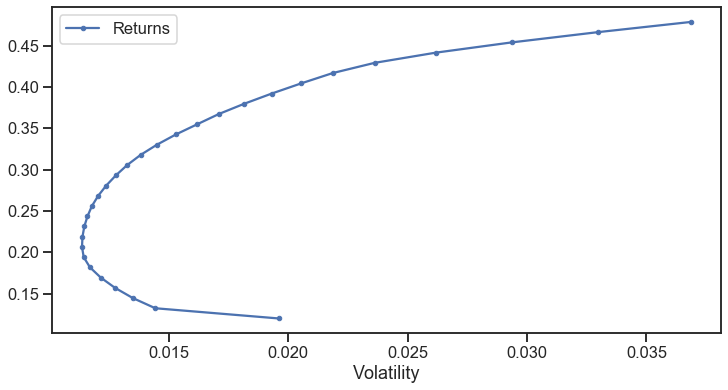

In [130]:
plot_ef(30, rets_anualizado[:-1], cov);

In [131]:
weights_for_all_assets = optimal_weights(30, rets_anualizado[:-1], cov)
weights_for_all_assets

[array([3.88578059e-16, 0.00000000e+00, 0.00000000e+00, 2.16768937e-07,
        2.16493490e-15, 7.04991621e-15, 0.00000000e+00, 9.99999783e-01]),
 array([0.00000000e+00, 0.00000000e+00, 8.48112720e-02, 4.47651667e-01,
        0.00000000e+00, 0.00000000e+00, 8.32667268e-17, 4.67537061e-01]),
 array([1.83366994e-18, 2.00414803e-02, 1.70893308e-01, 4.42563216e-01,
        0.00000000e+00, 0.00000000e+00, 3.87406563e-18, 3.66501995e-01]),
 array([0.00000000e+00, 8.91035922e-02, 1.93484413e-01, 3.95116293e-01,
        7.26954759e-18, 9.85412209e-18, 1.28704479e-18, 3.22295701e-01]),
 array([4.71515131e-18, 1.60993546e-01, 2.13127620e-01, 3.33796857e-01,
        0.00000000e+00, 0.00000000e+00, 4.72393146e-20, 2.92081976e-01]),
 array([7.56388851e-18, 2.21769646e-01, 2.45851471e-01, 3.03091946e-01,
        0.00000000e+00, 0.00000000e+00, 4.68943413e-19, 2.29286937e-01]),
 array([7.33467979e-18, 2.83884962e-01, 2.76747238e-01, 2.72725797e-01,
        0.00000000e+00, 1.16712557e-17, 0.00000000e+

## 10.2 - Achando o Portfólio com Maior Sharpe Ratio = MSR (Max Sharpe Ratio)

In [132]:
def msr(riskfree_rate, er, cov):
    """
    RiskFree rate + ER + COV  -> W
    
    RiskFree rate = RiskFree rate
    er = vector with expected returns of assets
    cov = covariance of assets
    """
    
    n = er.shape[0] # Number of assets
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n # multiplying tuple, boundary condition to weights
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights)-1
    }
    # If we want to maximize the sharpe ratio, we can minimize the negative sharpe ratio
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio, given weights
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol # negative of the sharpe ratio
        
    results = minimize(neg_sharpe_ratio, init_guess,
                       args=(riskfree_rate, er, cov,), method="SLSQP",
                       options={'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds
                      )
    
    return results.x

In [133]:
w_msr = msr(retorno_livre_de_risco, rets_anualizado[:-1], cov)
r_msr = portfolio_return(w_msr, rets_anualizado[:-1])
v_msr = portfolio_vol(w_msr, cov)
w_msr

array([1.30283950e-01, 3.56628430e-01, 4.70619134e-02, 0.00000000e+00,
       1.09193368e-13, 0.00000000e+00, 4.66025706e-01, 0.00000000e+00])

In [134]:
df_msr = pd.DataFrame({'Ações':rets_anualizado[:-1].index.tolist(),
                       'Pesos':w_msr,
                       'Retornos':r_msr,
                       'Vol':v_msr})
df_msr

,Ações,Pesos,Retornos,Vol
0,ELET3.SA,1.302839e-01,0.351599,0.015894
1,TRPL4.SA,3.566284e-01,0.351599,0.015894
2,TAEE11.SA,4.706191e-02,0.351599,0.015894
3,VIVT3.SA,0.000000e+00,0.351599,0.015894
4,CYRE3.SA,1.091934e-13,0.351599,0.015894
5,BBAS3.SA,0.000000e+00,0.351599,0.015894
6,SANB11.SA,4.660257e-01,0.351599,0.015894
7,BBSE3.SA,0.000000e+00,0.351599,0.015894


## 10.3 - Achando o Portfólio com a Mínima Volatilidade = GMV (Global Minimum Vol)

In [135]:
def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

In [136]:
w_gmv = gmv(cov)
r_gmv = portfolio_return(w_gmv,rets_anualizado[:-1])
v_gmv = portfolio_vol(w_gmv, cov)
w_gmv

array([0.        , 0.34227025, 0.2814076 , 0.23239506, 0.01501252,
       0.        , 0.0113317 , 0.11758287])

In [137]:
df_gmv = pd.DataFrame({'Ações':rets_anualizado[:-1].index.tolist(),
                       'Pesos':w_gmv,
                       'Retornos':r_gmv,
                       'Vol':v_gmv})
df_gmv

,Ações,Pesos,Retornos,Vol
0,ELET3.SA,0.000000,0.208538,0.011361
1,TRPL4.SA,0.342270,0.208538,0.011361
2,TAEE11.SA,0.281408,0.208538,0.011361
3,VIVT3.SA,0.232395,0.208538,0.011361
4,CYRE3.SA,0.015013,0.208538,0.011361
5,BBAS3.SA,0.000000,0.208538,0.011361
6,SANB11.SA,0.011332,0.208538,0.011361
7,BBSE3.SA,0.117583,0.208538,0.011361


## 10.4 - Plotando todos ao mesmo tempo

In [138]:
def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False, figsize=(12,6)):
    """
    Plots the multi-asset efficient frontier
    
    n_points = número de pontos para plotar o gráfico
    er = série de retornos anualizados
    cov = matriz de covariância
    show_cml = Mostrar o Capital Market Line?
    riskfree_rate = Retorno livre de risco, geralmente tomado como 12%
    show_ew = Destacar  o Portfólio EW?
    show_gmv = Destacar o Portfólio GMV?
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend, figsize=figsize)
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
        for i,j in zip([vol_msr], [r_msr]):
            ax.annotate('MSR: {}'.format(str(j)),xy=(i,j))
            
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # add EW
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
        for i,j in zip([vol_ew], [r_ew]):
            ax.annotate('EW: {}'.format(str(j)),xy=(i,j))
            
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # add GMV
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)
        for i,j in zip([vol_gmv], [r_gmv]):
            ax.annotate('GMV: {}'.format(str(j)),xy=(i,j))
        
        return ax

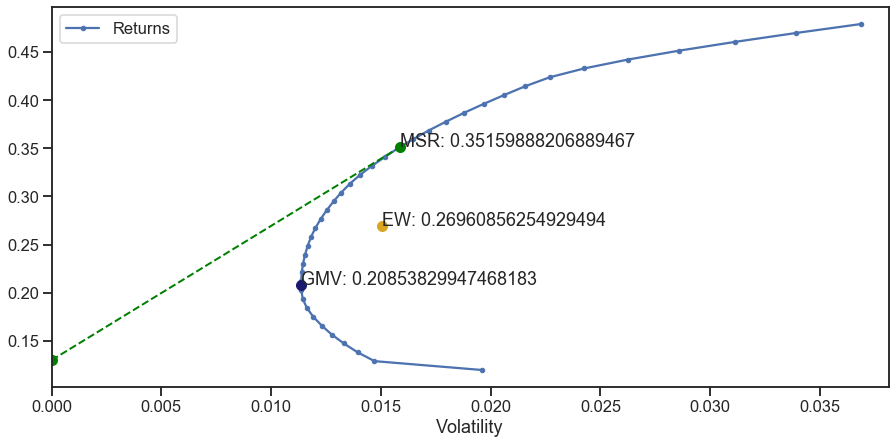

In [140]:
plot_ef(40, rets_anualizado[:-1], cov, legend=True, show_cml=True, riskfree_rate=retorno_livre_de_risco, show_ew=True, show_gmv=True, figsize=(15,7));

## 10.5 - Visualizando os portfólios

In [141]:
peso_portfolios = pd.DataFrame({'EW':w_ew, 'GMV':w_gmv, 'MSR':w_msr}, index=rets_anualizado[:-1].index.tolist())
peso_portfolios

,EW,GMV,MSR
ELET3.SA,0.125,0.000000,1.302839e-01
TRPL4.SA,0.125,0.342270,3.566284e-01
TAEE11.SA,0.125,0.281408,4.706191e-02
VIVT3.SA,0.125,0.232395,0.000000e+00
CYRE3.SA,0.125,0.015013,1.091934e-13
BBAS3.SA,0.125,0.000000,0.000000e+00
SANB11.SA,0.125,0.011332,4.660257e-01
BBSE3.SA,0.125,0.117583,0.000000e+00


In [142]:
retorno_portfolios = pd.DataFrame({'EW':r_ew, 'GMV':r_gmv, 'MSR':r_msr}, index=['Retorno'])
retorno_portfolios

,EW,GMV,MSR
Retorno,0.269609,0.208538,0.351599


In [143]:
vol_portfolios = pd.DataFrame({'EW':v_ew, 'GMV':v_gmv, 'MSR':v_msr}, index=['Vol'])
vol_portfolios

,EW,GMV,MSR
Vol,0.015034,0.011361,0.015894


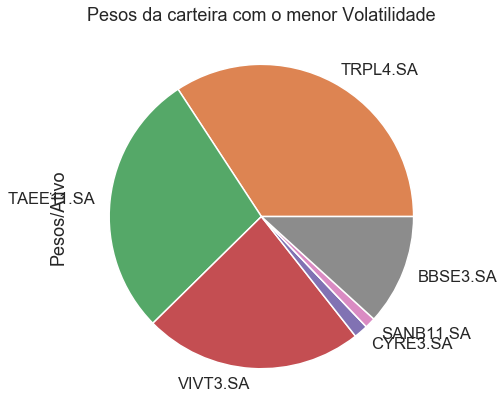

In [146]:
plt.figure(figsize=(15,7))
peso_portfolios['GMV'].plot(kind='pie')
plt.ylabel('Pesos/Ativo')
plt.title("Pesos da carteira com o menor Volatilidade")
plt.show()

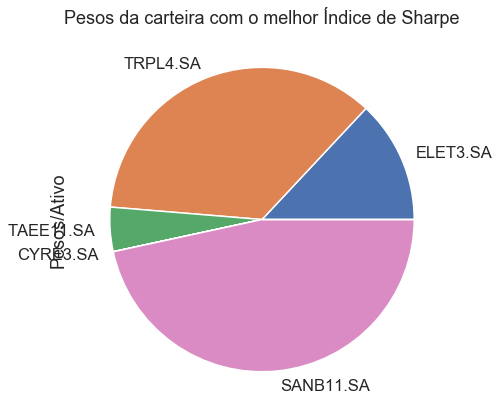

In [147]:
plt.figure(figsize=(15,7))
peso_portfolios['MSR'].plot(kind='pie')
plt.ylabel('Pesos/Ativo')
plt.title("Pesos da carteira com o melhor Índice de Sharpe")
plt.show()

In [ ]:
# Continuar com gráficos desse site
# https://dataml.com.br/otimizando-uma-carteira-de-criptomoedas-usando-python/

O que fazer no dia 09 de Junho?


- Fazer um código limpo que retorne todos os tipos de portfólios

- Calcular Risk Contributions and Risk Parity

- Fazer Backtesting dos portfólios

- Testar backtesting com IBOV e CDI (pegar taxa de SELIC no Período)

# 11 - Contribuição de Risco e Risk Parity

In [167]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

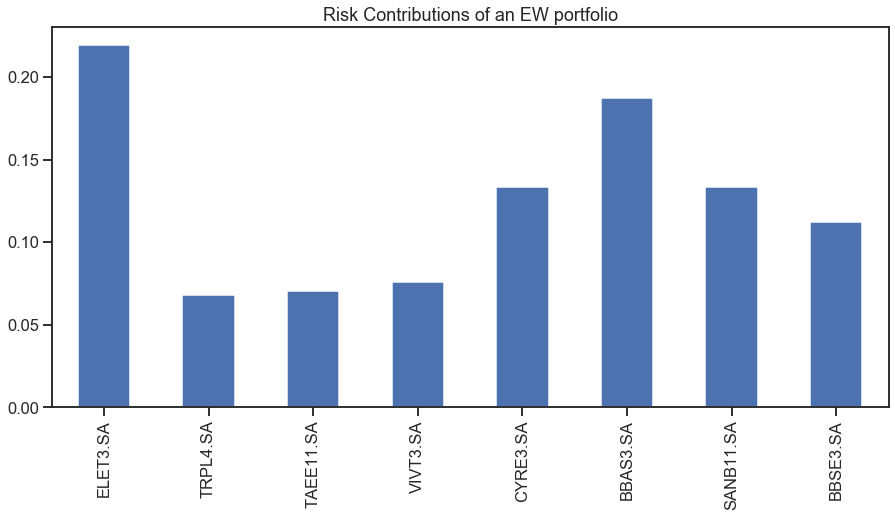

In [170]:
risk_contribution(w_ew, cov).plot.bar(figsize=(15,7), title="Risk Contributions of an EW portfolio");

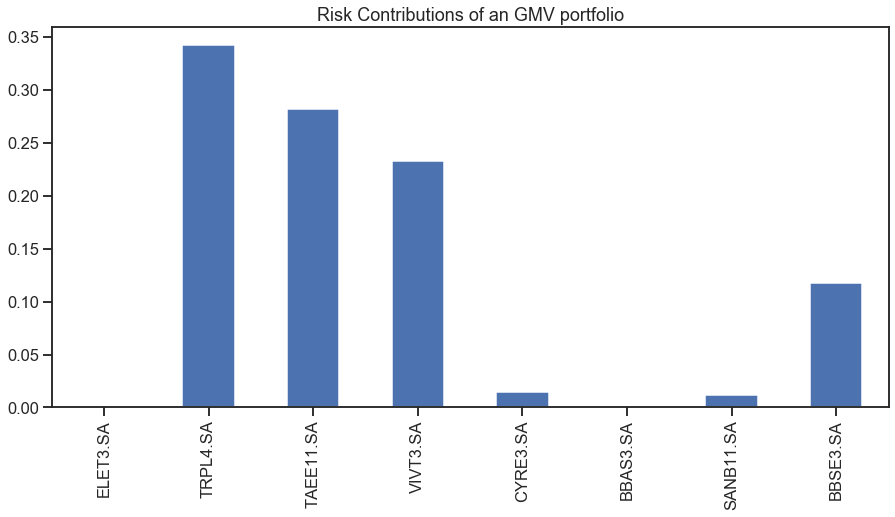

In [174]:
risk_contribution(w_gmv, cov).plot.bar(figsize=(15,7), title="Risk Contributions of an GMV portfolio");

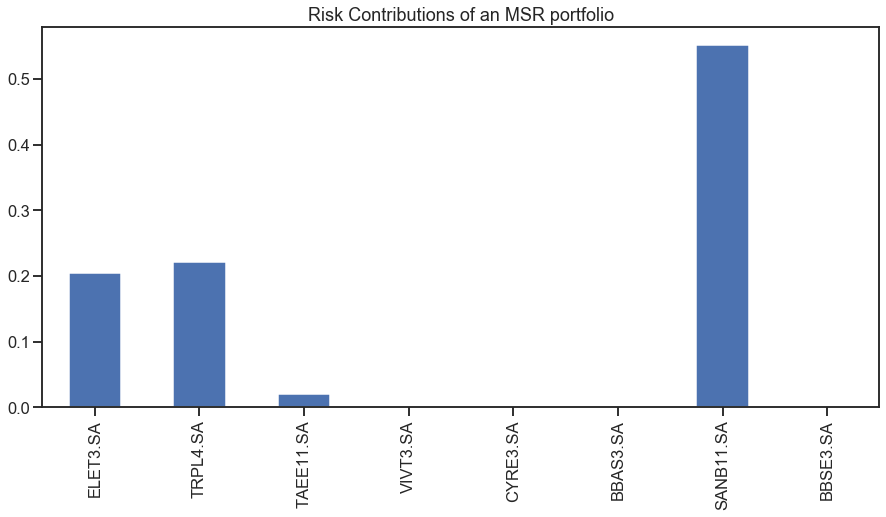

In [175]:
risk_contribution(w_msr, cov).plot.bar(figsize=(15,7), title="Risk Contributions of an MSR portfolio");

In [173]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x
###########################################################################################################################
def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

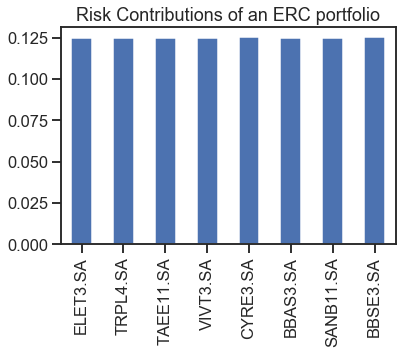

In [176]:
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

In [178]:
###########################################################################################################################
def weight_erc(cov):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    return equal_risk_contributions(cov)

In [180]:
w_ERC = equal_risk_contributions(cov)
w_ERC

array([0.07107754, 0.18161244, 0.17330393, 0.16194104, 0.10576484,
       0.07755266, 0.1056921 , 0.12305546])

# 12 - Backtesting das Carteiras

## 12.1 - Coletando Dados do CDI

In [148]:
def consulta_bc(codigo_bcb):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

In [157]:
cdi_historico = consulta_bc(12)

In [158]:
cdi_historico.head()

,valor
data,
1986-03-06,0.068111
1986-03-10,0.069028
1986-03-12,0.067417
1986-03-14,0.064584
1986-03-17,0.068222


In [159]:
inicio, fim

('01-01-2015', '01-01-2020')

In [160]:
cdi = cdi_historico.loc[inicio:fim]
cdi.head()

,valor
data,
2015-01-02,0.043455
2015-01-05,0.043455
2015-01-06,0.043455
2015-01-07,0.043455
2015-01-08,0.043455


In [163]:
cdi_acumulado = (1 + cdi/100).cumprod()
cdi_acumulado.head()

,valor
data,
2015-01-02,1.000435
2015-01-05,1.000869
2015-01-06,1.001304
2015-01-07,1.001739
2015-01-08,1.002175


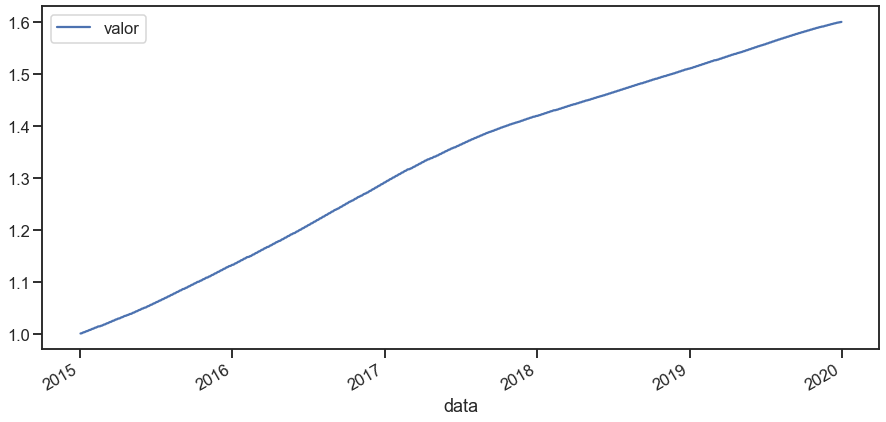

In [164]:
cdi_acumulado.plot(figsize=(15,7));

## 12.2 - Realizando o Backtesting

In [ ]:
def weight_ew(r):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def backtest_ws(r, estimation_window=60, weighting=weight_ew):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for each estimation window
    weights = [weighting(r.iloc[win[0]:win[1]]) for win in windows]
    # List -> DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

In [ ]:
ewr = backtest_ws(retornos, weighting=pd.Series(w_ew, index=retornos.columns))
ewi = (1+ewr).cumprod()
ewi.plot(figsize=(12,6), title="49 Industries - Equally Weighted");